<a href="https://colab.research.google.com/github/a-maksimov/data_analysis/blob/main/imdb_reviews_word2vec_sentiment_prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Defining the questions

Q.1 How accurate can we predict a positive or a negative sentiment of a movie review on Kinopoisk?

https://www.kaggle.com/datasets/mikhailklemin/kinopoisks-movies-reviews

In [ ]:
!unzip -oq '/content/drive/MyDrive/Datasets/Kinopoisk/kinopoisk_reviews.zip'

In [ ]:
import os
import pandas as pd
import re
import string
import spacy
from time import time
from datetime import datetime
from collections import defaultdict
from gensim.models import Word2Vec
import multiprocessing
from random import randint

/usr/local/lib/python3.9/dist-packages/torch/cuda/__init__.py:497: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")


In [ ]:
#@title Download spaCy language packs

!python -m spacy download ru_core_news_sm --quiet
!python -m spacy download en_core_web_sm --quiet

/usr/local/lib/python3.9/dist-packages/torch/cuda/__init__.py:497: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")
2023-03-09 15:48:46.816246: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/nvidia/lib:/usr/local/nvidia/lib64
2023-03-09 15:48:46.816402: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/nvidia/lib:/usr/local/nvidia/lib64
2023-03-09 15:48:46.816423: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Cannot dlopen some TensorRT libraries. If you would like to use Nvidia GPU with TensorRT, please make sure the missing libraries mentione

We label positive reviews as "1" and negative reviews as "0".

In [ ]:
review_dicts = []
filepath = '/content/dataset/neg/'
for filename in os.listdir(filepath):
  review_dict = {}
  review_dict['review_id'] = filename.split('.')[0]
  with open(filepath + filename, 'r', encoding='utf-8') as file:
    review_dict['review_content'] = file.read()
  review_dict['label'] = 0
  review_dicts.append(review_dict)

In [ ]:
filepath = '/content/dataset/pos/'
for filename in os.listdir(filepath):
  review_dict = {}
  review_dict['review_id'] = filename.split('.')[0]
  with open(filepath + filename, 'r', encoding='utf-8') as file:
    review_dict['review_content'] = file.read()
  review_dict['label'] = 1
  review_dicts.append(review_dict)

In [ ]:
df = pd.DataFrame.from_dict(review_dicts)

In [ ]:
df

,review_id,review_content,label
0,771095-0,Компания 20 Century Fox 34 года занималась про...,0
1,797840-28,Во время ловли магического носорога я ушла веш...,0
2,258924-39,"О фильме:\nФильм относится к жанру ужасов, о ч...",0
3,980011-24,Новаторство создателей телевизионных проектов ...,0
4,452720-0,Кто билетов купит пачку - тот получит тачку на...,0
...,...,...,...
106960,254888-1,"Неплохой криминальный фильм, неторопливостью и...",1
106961,230596-0,Предлагаю поговорить о 70-х. Думаете тогда кто...,1
106962,1104221-0,Документальное кино удивительным образом может...,1
106963,260981-19,Средства массовой информации плотно вошли в об...,1


In [ ]:
df = df.sample(frac=0.1, random_state=42).reset_index(drop=True)

Class imbalance of the dataset

In [ ]:
df['label'].value_counts(normalize=True)

1    0.811892
0    0.188108
Name: label, dtype: float64

In [ ]:
#@title Remove meantions, urls, RTs, emojis, symbols
def remove_emoji(text):
    emoji_pattern = re.compile("["
                               u"\U0001F600-\U0001F64F"  # emoticons
                               u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                               u"\U0001F680-\U0001F6FF"  # transport & map symbols
                               u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                               u"\U00002702-\U000027B0"
                               u"\U000024C2-\U0001F251"
                               "]+", flags=re.UNICODE)
    return emoji_pattern.sub(r'', text)


def brief_clean(text):
  text = re.sub('http\S*', '', text)  # remove urls
  text = remove_emoji(text)  # remove emojis
  text = text.translate(str.maketrans('', '', string.punctuation + '«»——–…“”©↓'))  # remove string.punctuation from the string
  text = text.replace('\n', ' ')  # replace newlines with space
  text = re.sub(' +', ' ', text)  # replace multiple spaces with one space
  text = text.lower().strip()  # make all lowercase and strip
  return text

In [ ]:
df['text_cleaned'] = df['review_content'].map(brief_clean)

In [ ]:
df

,review_id,review_content,label,text_cleaned
0,161007-79,"'Никто не знает, как возникла великая сила. Да...",1,никто не знает как возникла великая сила даже ...
1,77454-77,И чего же я столько времени откладывала просмо...,1,и чего же я столько времени откладывала просмо...
2,710276-45,"Так получилось, что в преддверии разрыва своих...",1,так получилось что в преддверии разрыва своих ...
3,690615-64,Игровая серия Assassin's creed прошла многолет...,0,игровая серия assassins creed прошла многолетн...
4,724-75,"Один из самых трогательных фильмов, которые я ...",1,один из самых трогательных фильмов которые я в...
...,...,...,...,...
10691,425926-10,"Потрясающей популярностью обладает это, на мой...",0,потрясающей популярностью обладает это на мой ...
10692,429039-45,Сразу скажу - фильм мне очень не понравился. М...,0,сразу скажу фильм мне очень не понравился можн...
10693,81491-15,Несмотря на любовь американцев к своему футбол...,1,несмотря на любовь американцев к своему футбол...
10694,89518-13,Моё знакомство с этим удивительным и незабывае...,1,моё знакомство с этим удивительным и незабывае...


In [ ]:
#@title Now we lemmatize without stop words
# Lemmatizes and removes stopwords
# doc needs to be a spacy Doc object

def lemmatize_without_stops(text):
  doc = nlp(text)
  lemmas = [token.lemma_ for token in doc if not token.is_stop]
  # Word2Vec uses context words to learn the vector representation of a target word,
  # if a sentence is only one or two words long,
  # the benefit for the training is very small
  if len(lemmas) > 2:
    return ' '.join(lemmas)

In [ ]:
#@title We load spaCy language packs and taking advantage of spaCy .pipe() method to speed-up the cleaning process.
language = "ru" #@param {type:"string"}
if language == 'ru':
  nlp = spacy.load('ru_core_news_sm', disable=['ner', 'parser'])  # disable Named Entity Recognition for speed
else:
  nlp = spacy.load('en_core_web_sm', disable=['ner', 'parser'])  # disable Named Entity Recognition for speed

https://prrao87.github.io/blog/spacy/nlp/performance/2020/05/02/spacy-multiprocess.html#Option-1:-Sequentially-process-DataFrame-column

In [ ]:
t = time()

# Lemmitize reviews
df['text_lem'] = df['text_cleaned'].apply(lemmatize_without_stops)

print(f'Time to lemmatize: {round((time() - t), 2)/60} mins')

Time to lemmatize: 23.2135 mins


In [ ]:
df

,review_id,review_content,label,text_cleaned,text_lem
0,161007-79,"'Никто не знает, как возникла великая сила. Да...",1,никто не знает как возникла великая сила даже ...,знать возникнуть великий сила книга проклятие ...
1,77454-77,И чего же я столько времени откладывала просмо...,1,и чего же я столько времени откладывала просмо...,столько время откладывать просмотр фильм класс...
2,710276-45,"Так получилось, что в преддверии разрыва своих...",1,так получилось что в преддверии разрыва своих ...,получиться преддверие разрыв отношение сходить...
3,690615-64,Игровая серия Assassin's creed прошла многолет...,0,игровая серия assassins creed прошла многолетн...,игровой серия assassins creed пройти многолетн...
4,724-75,"Один из самых трогательных фильмов, которые я ...",1,один из самых трогательных фильмов которые я в...,трогательный фильм видеть мег райан хью джекма...
...,...,...,...,...,...
10691,425926-10,"Потрясающей популярностью обладает это, на мой...",0,потрясающей популярностью обладает это на мой ...,потрясать популярность обладать взгляд безлики...
10692,429039-45,Сразу скажу - фильм мне очень не понравился. М...,0,сразу скажу фильм мне очень не понравился можн...,сказать фильм понравиться сказать плохой ужаст...
10693,81491-15,Несмотря на любовь американцев к своему футбол...,1,несмотря на любовь американцев к своему футбол...,несмотря любовь американец футбол похожему поб...
10694,89518-13,Моё знакомство с этим удивительным и незабывае...,1,моё знакомство с этим удивительным и незабывае...,знакомство удивительный незабываемый произведе...


In [ ]:
dt_string = datetime.now().strftime('%d-%m-%Y_%H-%M-%S')

In [ ]:
filepath = '/content/drive/MyDrive/Datasets/'
filename = f'kinopoisk_{len(df)}_reviews_lemmatized_{dt_string}'

In [ ]:
df.to_pickle(filepath + filename)

In [ ]:
df_clean = pd.read_pickle('/content/drive/MyDrive/Datasets/kinopoisk_10000_reviews_lemmatized')

In [ ]:
#@title Calculate word frequency

words_freq = defaultdict(int)
for review in df_clean['text_lem'].values:
  for word in review.split():
    words_freq[word] += 1

word_freq_df = pd.DataFrame.from_dict(words_freq, orient='index', columns=['word_count']).reset_index().rename(columns = {'index': 'word'})
word_freq_df.sort_values('word_count', ascending=False).head(10)

,word,word_count
155,фильм,46692
595,человек,12902
162,герой,11318
322,10,10133
170,жизнь,9202
129,главный,9010
423,хороший,8575
151,время,8149
500,история,7429
127,картина,7364


## Bigrams

We are using Gensim Phrases package to automatically detect common phrases (bigrams) from a list of sentences.

https://radimrehurek.com/gensim/models/phrases.html

In [ ]:
from gensim.models.phrases import Phrases, Phraser

Phrases() takes a list of list of words as input:

In [ ]:
sent = [row.split() for row in df_clean['text_lem']]

Creates the relevant phrases from the list of sentences:

In [ ]:
phrase_model = Phrases(sent, min_count=15)

In [ ]:
bigram = Phraser(phrase_model)

In [ ]:
sentences = bigram[sent]

In [ ]:
#@title Show bigrams
bigram_freq = defaultdict(int)
for sentence in sentences:
  for word in sentence:
     if '_' in word:
      bigram_freq[word] += 1

bigram_freq_df = pd.DataFrame.from_dict(bigram_freq, orient='index', columns=['bigram_count'])
bigram_freq_df.sort_values('bigram_count', ascending=False).head(20)

,bigram_count
главный_герой,3324
10_10,2266
8_10,1248
9_10,1165
актёрский_игра,953
главный_героиня,891
игра_актёр,885
7_10,849
актёрский_состав,766
первый_часть,714


# Model training

In [ ]:
cores = multiprocessing.cpu_count()

The parameters:
* sg ({0, 1}, optional) – Training algorithm: 1 for skip-gram; otherwise CBOW
* min_count = int - Ignores all words with total absolute frequency lower than this - (2, 100)
* window = int - The maximum distance between the current and predicted word within a sentence. E.g. window words on the left and window words on the left of our target - (2, 10)
* size = int - Dimensionality of the feature vectors. - (50, 300)
* sample = float - The threshold for configuring which higher-frequency words are randomly downsampled. Highly influencial. - (0, 1e-5)
* alpha = float - The initial learning rate - (0.01, 0.05)
* min_alpha = float - Learning rate will linearly drop to min_alpha as training progresses. To set it: alpha - (min_alpha * epochs) ~ 0.00
* negative = int - If > 0, negative sampling will be used, the int for negative specifies how many "noise words" should be drown. If set to 0, no negative sampling is used. - (5, 20)
* workers = int - Use these many worker threads to train the model (=faster training with multicore machines)


In [ ]:
dimensionality = 300

In [ ]:
w2v_model = Word2Vec(min_count=20,
                     window=4,
                     size=dimensionality,
                     sample=6e-5, 
                     alpha=0.03, 
                     min_alpha=0.0007, 
                     negative=20,
                     workers=cores-1)

In [ ]:
t = time()

w2v_model.build_vocab(sentences)

print(f'Time to build vocab: {round((time() - t), 2)} secs')
print(f'Vocabulary size: {len(w2v_model.wv.vocab)}')

Time to build vocab: 9.53 secs
Vocabulary size: 11759


In [ ]:
t = time()

w2v_model.train(sentences, total_examples=w2v_model.corpus_count, epochs=30)

print(f'Time to train the model: {round((time() - t), 2)/60} mins')

Time to train the model: 9.725333333333333 mins


In [ ]:
w2v_model.init_sims(replace=True)

In [ ]:
filepath = '/content/drive/MyDrive/Models/'
filename = 'w2v_'+ f'kinopoisk_{len(df)}_reviews_{dt_string}'

NameError: ignored

In [ ]:
w2v_model.save(filepath + filename)

In [ ]:
w2v_model = Word2Vec.load('/content/drive/MyDrive/Models/w2v_kinopoisk_10696_reviews_09-03-2023_23-20-35')

In [ ]:
#@title Select the word for showing the similarities
word = "\u0430\u0440\u0442\u0445\u0430\u0443\u0441" #@param {type:"string"}

In [ ]:
w2v_model.wv.most_similar(positive=[word])

[('авторский_кино', 0.6582237482070923),
 ('артхаусный', 0.546917200088501),
 ('заумный', 0.5421145558357239),
 ('фестивальный', 0.5377029180526733),
 ('мейнстрим', 0.5236610174179077),
 ('эстет', 0.5137270092964172),
 ('кино', 0.4942004680633545),
 ('феллини', 0.4902035593986511),
 ('европейский_кино', 0.4880061447620392),
 ('претенциозный', 0.4780024290084839)]

# Visualize

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
 
import seaborn as sns

from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

In [ ]:
#@title Plotting function

def tsnescatterplot(model, word, list_names):
    """ Plot in seaborn the results from the t-SNE dimensionality reduction algorithm of the vectors of a query word,
    its list of most similar words, and a list of words.
    """
    arrays = np.empty((0, dimensionality), dtype='f')
    word_labels = [word]
    color_list  = ['red']

    # adds the vector of the query word
    arrays = np.append(arrays, model.wv.__getitem__([word]), axis=0)
    
    # gets list of most similar words
    close_words = model.wv.most_similar([word])
    
    # adds the vector for each of the closest words to the array
    for wrd_score in close_words:
        wrd_vector = model.wv.__getitem__([wrd_score[0]])
        word_labels.append(wrd_score[0])
        color_list.append('blue')
        arrays = np.append(arrays, wrd_vector, axis=0)
    
    # adds the vector for each of the words from list_names to the array
    for wrd in list_names:
        wrd_vector = model.wv.__getitem__([wrd])
        word_labels.append(wrd)
        color_list.append('green')
        arrays = np.append(arrays, wrd_vector, axis=0)
        
    # Reduces the dimensionality from 300 dimensions with PCA
    reduc = PCA(n_components=len(arrays)).fit_transform(arrays)
    
    # Finds t-SNE coordinates for 2 dimensions
    np.set_printoptions(suppress=True)
        
    # Reduces the dimensionality from 300 to 2 dimensions with t-SNE
    Y = TSNE(n_components=2, random_state=0, perplexity=15).fit_transform(arrays)
        
    # Sets everything up to plot
    df = pd.DataFrame({'x': [x for x in Y[:, 0]],
                       'y': [y for y in Y[:, 1]],
                       'words': word_labels,
                       'color': color_list})
    
    fig, _ = plt.subplots()
    fig.set_size_inches(9, 9)
    
    # Basic plot
    p1 = sns.regplot(data=df,
                     x="x",
                     y="y",
                     fit_reg=False,
                     marker="o",
                     scatter_kws={'s': 40,
                                  'facecolors': df['color']
                                 }
                    )
    
    # Adds annotations one by one with a loop
    for line in range(0, df.shape[0]):
         p1.text(df["x"][line],
                 df['y'][line],
                 '  ' + df["words"][line].title(),
                 horizontalalignment='left',
                 verticalalignment='bottom', size='medium',
                 color=df['color'][line],
                 weight='normal'
                ).set_size(15)

    
    plt.xlim(Y[:, 0].min()-50, Y[:, 0].max()+50)
    plt.ylim(Y[:, 1].min()-50, Y[:, 1].max()+50)
            
    plt.title('t-SNE visualization for {}'.format(word.title()))

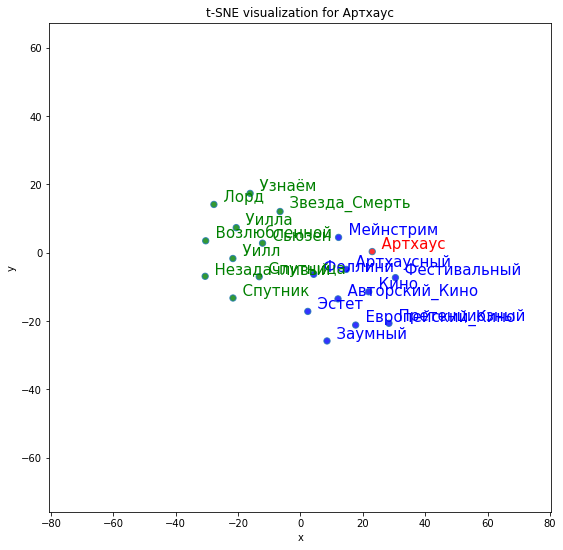

In [ ]:
tsnescatterplot(w2v_model, word, [i[0] for i in w2v_model.wv.most_similar(negative=[word])])

# Machine learning

We load the trained Word2Vec model and generate word embeddings for a set of documents in a corpus.

Since doc_embedding is a two-dimensional array, where each row represents a word embedding and each column represents a dimension of the embedding space, taking the mean along axis 0 results in a new one-dimensional array where each element represents the mean value of the corresponding column across all the word embeddings in the document.

By taking the mean of the word embeddings, we obtain a single vector representation of the document that summarizes the semantic information of all the words in the document. This is commonly referred to as a "document-level embedding" or "document vector".

 We use them as features

In [ ]:
#@title Get the average of the word embeddings of a document to get a document-level embedding
def get_doc_embedding(doc) -> list:
    doc_embeddings = [w2v_model.wv[word] for word in doc.split() if word in w2v_model.wv.vocab]
    if len(doc_embeddings) > 0:
        return np.mean(doc_embeddings, axis=0)

In [ ]:
df_clean['text_embedding'] = df_clean['text_lem'].apply(get_doc_embedding)

When using document-level embeddings as features in a machine learning model, it is common to split the embedding vector into separate columns, with each column representing a different dimension of the embedding space.

In [ ]:
embedding_cols = [f'embedding_{i+1}' for i in range(dimensionality)]

In [ ]:
df_clean[embedding_cols] = pd.DataFrame(df_clean['text_embedding'].to_list())

In [ ]:
from sklearn.model_selection import train_test_split

In [ ]:
train, test = train_test_split(df_clean, train_size=0.6, random_state=42, stratify=df['label'])
val, test = train_test_split(test, train_size=0.5, random_state=42, stratify=test['label'])

In [ ]:
!pip install catboost --quiet

In [ ]:
from catboost import CatBoostClassifier

In [ ]:
input = embedding_cols
output = ['label']

In [ ]:
model = CatBoostClassifier(
    verbose=100,
    random_seed=42,
    learning_rate=0.01,
    iterations=1999
)

In [ ]:
model.fit(train[input], train[output], eval_set=(val[input], val[output]))

0:	learn: 0.6859683	test: 0.6861675	best: 0.6861675 (0)	total: 110ms	remaining: 3m 39s
100:	learn: 0.3673821	test: 0.3779818	best: 0.3779818 (100)	total: 8.96s	remaining: 2m 48s
200:	learn: 0.2962197	test: 0.3195397	best: 0.3195397 (200)	total: 18.8s	remaining: 2m 48s
300:	learn: 0.2629020	test: 0.2976351	best: 0.2976351 (300)	total: 29.3s	remaining: 2m 45s
400:	learn: 0.2409504	test: 0.2859840	best: 0.2859840 (400)	total: 37.5s	remaining: 2m 29s
500:	learn: 0.2236002	test: 0.2781689	best: 0.2781689 (500)	total: 50.5s	remaining: 2m 31s
600:	learn: 0.2088963	test: 0.2724763	best: 0.2724763 (600)	total: 1m	remaining: 2m 19s
700:	learn: 0.1955894	test: 0.2683918	best: 0.2683918 (700)	total: 1m 8s	remaining: 2m 6s
800:	learn: 0.1835157	test: 0.2645560	best: 0.2645560 (800)	total: 1m 18s	remaining: 1m 57s
900:	learn: 0.1723694	test: 0.2620425	best: 0.2620425 (900)	total: 1m 26s	remaining: 1m 45s
1000:	learn: 0.1611979	test: 0.2593785	best: 0.2593785 (1000)	total: 1m 36s	remaining: 1m 36s
11

In [ ]:
test['score'] = model.predict_proba(test[input])[:, 1]

In [ ]:
test[['review_id', 'label', 'score']]

,review_id,label,score
3987,839711-21,0,0.030452
10616,826373-0,1,0.983117
941,260983-85,1,0.581642
8669,477764-51,1,0.857682
9889,591929-24,1,0.993608
...,...,...,...
6278,566232-28,0,0.003958
7014,675216-79,1,0.621083
889,584612-4,1,0.987136
9418,408661-5,1,0.989876


Log loss, also known as cross-entropy loss, is a loss function used in classification tasks to measure the difference between predicted probabilities and true labels. It is a commonly used loss function in machine learning algorithms such as logistic regression and neural networks.

The log loss formula is:

\begin{equation}
-\log P(y|x),
\end{equation}

where $P(y|x)$ is the predicted probability of class $y$ given input $x$. Log loss penalizes incorrect predictions more heavily than correct predictions.

In [ ]:
from sklearn.metrics import log_loss

In [ ]:
def print_metrics():
  print(log_loss(test['label'], test['score']))

In [ ]:
print_metrics()

0.24547344242788913


# Classification metrics

In [ ]:
test['pred'] = (test['score'] > 0.5) * 1

In [ ]:
test[['review_id', 'label', 'score', 'pred']]

,review_id,label,score,pred
3987,839711-21,0,0.030452,0
10616,826373-0,1,0.983117,1
941,260983-85,1,0.581642,1
8669,477764-51,1,0.857682,1
9889,591929-24,1,0.993608,1
...,...,...,...,...
6278,566232-28,0,0.003958,0
7014,675216-79,1,0.621083,1
889,584612-4,1,0.987136,1
9418,408661-5,1,0.989876,1


In [ ]:
from sklearn.metrics import classification_report

In [ ]:
print(classification_report(test['label'], test['pred']))

              precision    recall  f1-score   support

           0       0.79      0.60      0.69       403
           1       0.91      0.96      0.94      1737

    accuracy                           0.90      2140
   macro avg       0.85      0.78      0.81      2140
weighted avg       0.89      0.90      0.89      2140



# ROC curve

In [ ]:
thrs = [0] + list(test['score'].unique())

In [ ]:
from sklearn.metrics import f1_score

In [ ]:
#@title Add progress bar
from tqdm.notebook import tqdm

In [ ]:
result = []
for thr in tqdm(thrs):
  test['pred_new'] = (test['score'] > thr) * 1
  result.append((thr, f1_score(test['label'], test['pred_new'])))

  0%|          | 0/2141 [00:00<?, ?it/s]

In [ ]:
#Find the best threshold
best_thr, best_f1 = max(result, key=lambda pair: pair[1])
best_thr, best_f1

(0.49926712629279, 0.937552506300756)

In [ ]:
test['pred_new'] = (test['score'] > best_thr) * 1

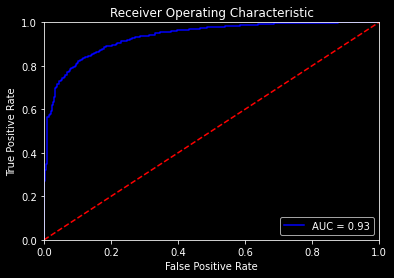

In [ ]:
import sklearn.metrics as metrics
# calculate the fpr and tpr for all thresholds of the classification

fpr, tpr, threshold = metrics.roc_curve(test['label'], test['score'])
roc_auc = metrics.auc(fpr, tpr)

# method I: plt
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

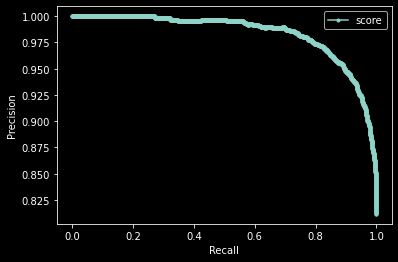

In [ ]:
from sklearn.datasets import make_classification
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import f1_score
from sklearn.metrics import auc
from matplotlib import pyplot

precision1, recall1, _ = precision_recall_curve(test['label'], test['score'])

# plot the precision-recall curves
pyplot.plot(recall1, precision1, marker='.', label='score')
# axis labels
pyplot.xlabel('Recall')
pyplot.ylabel('Precision')
# show the legend
pyplot.legend()
# show the plot
pyplot.show()

# Play

Обзоры на Чебурашку с Киноафишы

In [ ]:
review_1 = '''Я хочу сказать вам огоромное «СПАСИБО» за такой фильм!
Смотрел трейлер, думал очередной фильмишка, но ради Чебурашки схожу.
Знаете, я ошибался и очень рад этому.
В этом фильме 85% сюжета с чебурашкой, это замечательно, что не стали строить фильм на людях, а включили почти в весь сюжет милого персонажа
Благодаря фильму, я увидел новую интерпретацию советского мультика. У вас получилось!
Чебурашка стал для меня на всю жизнь чем-то добрым, не винным, замечательным персонажем. 
В некоторых моментах фильма хочется, чтобы он был в нашей реальности.
По началу смеешься над чебурашкой, потом плачешь из-за сплетения 2 историй, прошлой и настоящей.
Гена, в прошлом потерял жену и отдал свою дочь, и в настоящем он чтобы защитить свою взрослую дочь отдает ЧЕБУРАШКУ шапокляке.
В тот момент весь зрительный зал плакал.
По итогу, чебурашка разочаровывается в людях. Он сказал, что все люди плахие. Когда он это говорит, хочется еще раз плакать.
Потом еще раз все плачут из-за того, что в развязки у них все наладилось, они все вместе и в финале Гена на гармошке играет легендарную песню.
А я играю, на гармошке...
ОГРОМНОЕ ВАМ СПАСИБО ЗА ФИЛЬМ!
Сходите, не пожалете!'''

In [ ]:
review_2 = '''Финальная рецензия. :)
Такой откровенной ХАЛТУРЫ я в кинотеатре еще не смотрел!
Анимация низкокачественная, не «врисованна» в картину, а «приклеена» к ней! Местами персонаж двигается отдельно от фона. 
Даже волосяной покров на чебурашке упорно не хочет шевелиться.
Сюжет к Чебурашке притянут «за уши».
Авторские посылы увиденные мной приведены ниже.
Авторский посыл 1: Главное — семья, но семья этого не оценит! «Безысходность»?
Авторский посыл 2: Малый бизнес — это хорошо, но заниматься им нет смысла т. к. вас 100% задушит крупный бизнес с низкопробным продуктом!
«Безысходность» или отсылка к крупным партнерам в титрах?
Авторский посыл 3: забудьте о деньгах, живите для семьи и не «высовывайтесь», иначе Вас втопчут в грязь более «эффективные бизнесмены/менеджеры».
Намек подрастающему поколению о безысходности?! Добавлю, в кино из «недружественных» стран обычно «пресмыкание» показано с точки зрения высмеивания персонажей окружающих «успешного»/богатого/властного человека ("шакалов»), а здесь это преподнесено как норма общения с «успешными людьми»!
И еще раз про «Безысходность» — это фраза Чебурашки из фильма!!!
Если кратко о фильме, то это аналог сериала «Кухня», только с Гармашем, Добронравовым , Яковлевой и Чебурашкой (непонятно зачем он здесь т. к. не отпускает ощущение, что его «вписали» в уже готовый сценарий фильма), местами вызывает улыбку, местами давит на слезу, но в целом ЭТО ВТОРОСОРТНЫЙ ПРОДУКТ ДЛЯ ТВ, но никак НЕ ДЛЯ КИНОТЕАТРА.
Причины высоких сборов: Безысходность!!! Агрессивные реклама и пиар + в кинотеатр с ребенком сейчас больше не на что пойти…'''

In [ ]:
df_play = pd.DataFrame()
df_play = df_play.append(pd.DataFrame(get_doc_embedding(lemmatize_without_stops(brief_clean(review_1))).reshape(1,-1), columns=embedding_cols)).copy()
df_play = df_play.append(pd.DataFrame(get_doc_embedding(lemmatize_without_stops(brief_clean(review_2))).reshape(1,-1), columns=embedding_cols)).copy()

In [ ]:
df_play['score'] = model.predict_proba(df_play[input])[:, 1]
df_play['pred'] = (df_play['score'] > best_thr) * 1
df_play[['score', 'pred']]

,score,pred
0,0.989962,1
0,0.140314,0
